# Fuel depletion

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name='Snow'

During this datalab we will investigate how the fuel composition changes during the reactor operation. For this we will use openmc's `deplete` module. OpenMC solves the transport problem with a Monte Carlo approach to obtain reaction rates, and then the Batemen-equations are solved with these reaction rates. Nevertheless, the coupling between the depletion and the transport calculation is not a trivial task, there are various coupling schemes to achieve that. Within this datalab we do not look into the depth of various coupling techniques, and we will just use the most default settings.

In order to achieve an accurate depletion study one needs to have as many time steps when the depletion equations are solved as possible, and due to this, burnup calculations are time consuming, espescially when the reaction rates are based on Monte Carlo transport solvers. During this datalab we will focus on the phenomena and on qualitative results, therefore we will not care about accuracy. That said we will use only few particles per batch, and very long depletion steps. We will also neglect downtime periods (when the reactor is not operating).

The lab is going to have two experiments.

1. We will use our good old PWR pincell model to investigate how the neutron spectrum, the k-eigenvalue and the nuclide concentrations change over time
2. We will build a graphite moderated, natural uranium fuelled reactor's pincell model to estimate the Plutonium production. This is already part of your last set of home assignments, so don't feel stressed to finish it today.

Let's get started.

## Experiment 1

First, we will define the same PWR pincell model as in the previous datalabs. The only newly added feature here is that we set the `volume` attribute for the object `uo2`. This is necessary for burnup calculations. Since we have an axially infinite pin, we only gave the cross sectional area of the pin. In the latest version of openMC the `deplete.Operator` requires a `Model` object as an input, therefore add the geometry, materials, settings and tallies to a `Model()`. (If, for any reason, you are using an older version, we kept the related lines commented out, and you can switch to that.)

You can execute the code below. And you can already execute the next code block, because it takes some time to run. During that time you can do the reading.

In [10]:
import openmc
import math
import os
import numpy as np
import matplotlib.pyplot as plt
path = '/root/jeff-3.3-hdf5/cross_sections.xml'

uo2 = openmc.Material(1, "uo2", temperature=1200)
# Add nuclides to uo2
uo2.add_nuclide('U235', 0.04)
uo2.add_nuclide('U238', 0.96)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.5)
uo2.volume = math.pi * 0.41 ** 2

zirconium = openmc.Material(2, "zirconium", temperature=900)
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

water = openmc.Material(3, "h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 0.75)
water.add_s_alpha_beta('c_H_in_H2O')



mats = openmc.Materials([uo2, zirconium, water])
mats.cross_sections = path

#mats.export_to_xml()

fuel_or = openmc.ZCylinder(r=0.41)
clad_ir = openmc.ZCylinder(r=0.42)
clad_or = openmc.ZCylinder(r=0.45)



fuel_region = -fuel_or
gap_region = +fuel_or & -clad_ir
clad_region = +clad_ir & -clad_or

fuel = openmc.Cell(1, 'fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(2, 'air gap')
gap.region = gap_region

clad = openmc.Cell(3, 'clad')
clad.fill = zirconium
clad.region = clad_region

pitch = 1.26
left = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, boundary_type='reflective')

water_region = +left & -right & +bottom & -top & +clad_or

moderator = openmc.Cell(4, 'moderator')
moderator.fill = water
moderator.region = water_region

root = openmc.Universe(cells=(fuel, gap, clad, moderator))

geom = openmc.Geometry()
geom.root_universe = root
#geom.export_to_xml()


cell_filter = openmc.CellFilter(fuel)
energybins=np.logspace(-2,7,500)
energy_filter = openmc.EnergyFilter(energybins)

t = openmc.Tally(1)
t.filters = [cell_filter,energy_filter]
t.scores = ['flux']
tallies = openmc.Tallies([t])
tallies.export_to_xml()
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)

settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 500
settings.export_to_xml()

#geometry = openmc.Geometry.from_xml()
#settings = openmc.Settings.from_xml()

model = openmc.model.Model(geom, mats, settings, tallies)

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=4.
  warn(msg, IDWarning)
/

Now, instead of just running the code as before, we will set up the depletion calculation. For further details you can visit the [documentation](https://docs.openmc.org/en/stable/usersguide/depletion.html). We will need to do several things:

1. define an `Operator()` object, which will be our transport operator. Here we link the geometry and the settings objects through a `Model()`.
2. within the operator we provide the path to the depletion chain we would like to use. OpenMC provides some [pre-generated chains](https://openmc.org/depletion-chains/). This is used for the depletion solver to set up the Batemen-equations.
3. we define a power or a power density (below we defined the power density in W/gHeavyMetal)
4. we define the depletion steps. This we can give in time or in burnup units, below 8 steps are given each are 5 MWd/kgU.
5. Then we define an integrator (the scheme how the transport and the depletion is coupled). OpenMC provides other, more accurate, and more demanding schemes, which you can find in the documentation.
6. Finally we call the `integrate()` method of the integrator. This will run the simulation.

By default openMC is going to deplete every material which contains fissionable isotopes.

(**Note**, in case you have difficulties with running the problem -which might happen with the virtual machine and limited computational resources-, then you can find the output files in the '/results' folder, you only need to modify the path in the code blocks performing the the post-processing to use these files).

In [13]:
import openmc.deplete
import os

#operator = openmc.deplete.Operator(geom, settings, '/home/rfp/Depletion_chains/chain_casl_pwr.xml')
operator = openmc.deplete.CoupledOperator(model, '/root/data/depletion/chain_casl_pwr.xml')

powdens = 27.39726 #W/gHM; this power density corresponds to 10MWd/kgHM burnup over one year


burnup_steps = np.array([5,5,5,5,5,5,5,5])

integrator = openmc.deplete.PredictorIntegrator(operator, timesteps=burnup_steps,
                                                power_density=powdens,timestep_units='MWd/kg')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo94 from /root/jeff-3.3-hdf5/Mo94.h5
 Reading Mo95 from /root/jeff-3.3-hdf5/Mo95.h5
 Reading Mo96 from /root/jeff-3.3-hdf5/Mo96.h5
 Reading Mo97 from /root/jeff-3.3-hdf5/Mo97.h5
 Reading Mo98 from /root/jeff-3.3-hdf5/Mo98.h5
 Reading Mo99 from /root/jeff-3.3-hdf5/Mo99.h5
 Reading Mo100 from /root/jeff-3.3-hdf5/Mo100.h5
 Reading Tc99 from /root/jeff-3.3-hdf5/Tc99.h5


          1200K
          2500K


 Reading Ru100 from /root/jeff-3.3-hdf5/Ru100.h5
 Reading Ru101 from /root/jeff-3.3-hdf5/Ru101.h5
 Reading Ru102 from /root/jeff-3.3-hdf5/Ru102.h5
 Reading Ru103 from /root/jeff-3.3-hdf5/Ru103.h5
 Reading Ru104 from /root/jeff-3.3-hdf5/Ru104.h5
 Reading Ru105 from /root/jeff-3.3-hdf5/Ru105.h5
 Reading Ru106 from /root/jeff-3.3-hdf5/Ru106.h5
 Reading Rh102 from /root/jeff-3.3-hdf5/Rh102.h5
 Reading Rh103 from /root/jeff-3.3-hdf5/Rh103.h5
 Reading Rh104 from /root/jeff-3.3-hdf5/Rh104.h5
 Reading Rh105 from /root/jeff-3.3-hdf5/Rh105.h5
 Reading Pd104 from /root/jeff-3.3-hdf5/Pd104.h5
 Reading Pd105 from /root/jeff-3.3-hdf5/Pd105.h5
 Reading Pd106 from /root/jeff-3.3-hdf5/Pd106.h5
 Reading Pd107 from /root/jeff-3.3-hdf5/Pd107.h5
 Reading Pd108 from /root/jeff-3.3-hdf5/Pd108.h5
 Reading Ag107 from /root/jeff-3.3-hdf5/Ag107.h5
 Reading Ag109 from /root/jeff-3.3-hdf5/Ag109.h5
 Reading Ag110 from /root/jeff-3.3-hdf5/Ag110.h5


          1200K
          2500K


 Reading Ag110_m1 from /root/jeff-3.3-hdf5/Ag110_m1.h5
 Reading Ag111 from /root/jeff-3.3-hdf5/Ag111.h5
 Reading Cd110 from /root/jeff-3.3-hdf5/Cd110.h5
 Reading Cd111 from /root/jeff-3.3-hdf5/Cd111.h5
 Reading Cd112 from /root/jeff-3.3-hdf5/Cd112.h5
 Reading Cd113 from /root/jeff-3.3-hdf5/Cd113.h5
 Reading Cd114 from /root/jeff-3.3-hdf5/Cd114.h5
 Reading In113 from /root/jeff-3.3-hdf5/In113.h5
 Reading In115 from /root/jeff-3.3-hdf5/In115.h5
 Reading Sb121 from /root/jeff-3.3-hdf5/Sb121.h5
 Reading Sb123 from /root/jeff-3.3-hdf5/Sb123.h5
 Reading Sb125 from /root/jeff-3.3-hdf5/Sb125.h5
 Reading Sb127 from /root/jeff-3.3-hdf5/Sb127.h5
 Reading Te127_m1 from /root/jeff-3.3-hdf5/Te127_m1.h5
 Reading Te129_m1 from /root/jeff-3.3-hdf5/Te129_m1.h5


          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Te132 from /root/jeff-3.3-hdf5/Te132.h5
 Reading I127 from /root/jeff-3.3-hdf5/I127.h5
 Reading I128 from /root/jeff-3.3-hdf5/I128.h5
 Reading I129 from /root/jeff-3.3-hdf5/I129.h5
 Reading I130 from /root/jeff-3.3-hdf5/I130.h5
 Reading I131 from /root/jeff-3.3-hdf5/I131.h5
 Reading I135 from /root/jeff-3.3-hdf5/I135.h5
 Reading Xe128 from /root/jeff-3.3-hdf5/Xe128.h5
 Reading Xe130 from /root/jeff-3.3-hdf5/Xe130.h5
 Reading Xe131 from /root/jeff-3.3-hdf5/Xe131.h5
 Reading Xe132 from /root/jeff-3.3-hdf5/Xe132.h5
 Reading Xe133 from /root/jeff-3.3-hdf5/Xe133.h5
 Reading Xe134 from /root/jeff-3.3-hdf5/Xe134.h5
 Reading Xe135 from /root/jeff-3.3-hdf5/Xe135.h5
 Reading Xe135_m1 from /root/jeff-3.3-hdf5/Xe135_m1.h5
 Reading Xe136 from /root/jeff-3.3-hdf5/Xe136.h5


          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Cs133 from /root/jeff-3.3-hdf5/Cs133.h5
 Reading Cs134 from /root/jeff-3.3-hdf5/Cs134.h5
 Reading Cs135 from /root/jeff-3.3-hdf5/Cs135.h5
 Reading Cs136 from /root/jeff-3.3-hdf5/Cs136.h5
 Reading Cs137 from /root/jeff-3.3-hdf5/Cs137.h5
 Reading Ba134 from /root/jeff-3.3-hdf5/Ba134.h5
 Reading Ba137 from /root/jeff-3.3-hdf5/Ba137.h5
 Reading Ba140 from /root/jeff-3.3-hdf5/Ba140.h5
 Reading La139 from /root/jeff-3.3-hdf5/La139.h5
 Reading La140 from /root/jeff-3.3-hdf5/La140.h5
 Reading Ce140 from /root/jeff-3.3-hdf5/Ce140.h5
 Reading Ce141 from /root/jeff-3.3-hdf5/Ce141.h5
 Reading Ce142 from /root/jeff-3.3-hdf5/Ce142.h5
 Reading Ce143 from /root/jeff-3.3-hdf5/Ce143.h5
 Reading Ce144 from /root/jeff-3.3-hdf5/Ce144.h5
 Reading Pr141 from /root/jeff-3.3-hdf5/Pr141.h5
 Reading Pr142 from /root/jeff-3.3-hdf5/Pr142.h5
 Reading Pr143 from /root/jeff-3.3-hdf5/Pr143.h5
 Reading Nd142 from /root/jeff-3.3-hdf5/Nd142.h5
 Reading Nd143 from /root/jeff-3.3-hdf5/Nd143.h5
 Reading Nd144 from 

 Reading Nd150 from /root/jeff-3.3-hdf5/Nd150.h5
 Reading Pm147 from /root/jeff-3.3-hdf5/Pm147.h5
 Reading Pm148 from /root/jeff-3.3-hdf5/Pm148.h5
 Reading Pm148_m1 from /root/jeff-3.3-hdf5/Pm148_m1.h5
 Reading Pm149 from /root/jeff-3.3-hdf5/Pm149.h5


          250K
          294K
          600K
          900K
          1200K
          2500K


 Reading Pm151 from /root/jeff-3.3-hdf5/Pm151.h5
 Reading Sm147 from /root/jeff-3.3-hdf5/Sm147.h5
 Reading Sm148 from /root/jeff-3.3-hdf5/Sm148.h5
 Reading Sm149 from /root/jeff-3.3-hdf5/Sm149.h5
 Reading Sm150 from /root/jeff-3.3-hdf5/Sm150.h5
 Reading Sm151 from /root/jeff-3.3-hdf5/Sm151.h5
 Reading Sm152 from /root/jeff-3.3-hdf5/Sm152.h5
 Reading Sm153 from /root/jeff-3.3-hdf5/Sm153.h5
 Reading Sm154 from /root/jeff-3.3-hdf5/Sm154.h5
 Reading Eu151 from /root/jeff-3.3-hdf5/Eu151.h5
 Reading Eu152 from /root/jeff-3.3-hdf5/Eu152.h5
 Reading Eu152_m1 from /root/jeff-3.3-hdf5/Eu152_m1.h5
 Reading Eu153 from /root/jeff-3.3-hdf5/Eu153.h5
 Reading Eu154 from /root/jeff-3.3-hdf5/Eu154.h5
 Reading Eu155 from /root/jeff-3.3-hdf5/Eu155.h5
 Reading Eu156 from /root/jeff-3.3-hdf5/Eu156.h5
 Reading Eu157 from /root/jeff-3.3-hdf5/Eu157.h5
 Reading Gd152 from /root/jeff-3.3-hdf5/Gd152.h5
 Reading Gd154 from /root/jeff-3.3-hdf5/Gd154.h5
 Reading Gd155 from /root/jeff-3.3-hdf5/Gd155.h5
 Reading Gd156

          1200K


 Reading Pu236 from /root/jeff-3.3-hdf5/Pu236.h5
 Reading Pu237 from /root/jeff-3.3-hdf5/Pu237.h5
 Reading Pu238 from /root/jeff-3.3-hdf5/Pu238.h5
 Reading Pu239 from /root/jeff-3.3-hdf5/Pu239.h5
 Reading Pu240 from /root/jeff-3.3-hdf5/Pu240.h5
 Reading Pu241 from /root/jeff-3.3-hdf5/Pu241.h5
 Reading Pu242 from /root/jeff-3.3-hdf5/Pu242.h5
 Reading Pu243 from /root/jeff-3.3-hdf5/Pu243.h5
 Reading Am241 from /root/jeff-3.3-hdf5/Am241.h5
 Reading Am242 from /root/jeff-3.3-hdf5/Am242.h5
 Reading Am242_m1 from /root/jeff-3.3-hdf5/Am242_m1.h5
 Reading Am243 from /root/jeff-3.3-hdf5/Am243.h5
 Reading Am244 from /root/jeff-3.3-hdf5/Am244.h5
 Reading Am244_m1 from /root/jeff-3.3-hdf5/Am244_m1.h5
 Reading Cm242 from /root/jeff-3.3-hdf5/Cm242.h5
 Reading Cm243 from /root/jeff-3.3-hdf5/Cm243.h5
 Reading Cm244 from /root/jeff-3.3-hdf5/Cm244.h5
 Reading Cm245 from /root/jeff-3.3-hdf5/Cm245.h5
 Reading Cm246 from /root/jeff-3.3-hdf5/Cm246.h5
 Maximum neutron transport energy: 20000000 eV for H1
 In

If you list the contents of the folder, you can see that several several h5 output files were created. Some are called 'openmc_simulation_nN.h5 (where N is the index of the depletion step, 0 stands for zero burnup). These files contain the tally results. We had only one tally this time with id 1.

Let's plot the group flux per source particle for the 0th step (fresh fuel) and for the 8th step (40 MWd/kgU). Do you notice any change? If yes, what do you think what is the reason for that?

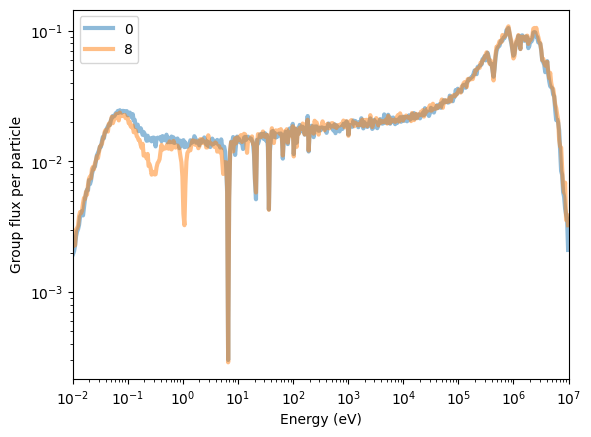

In [17]:
import matplotlib.pyplot as plt
plt.figure()
for i in [0,8]:
    #print('openmc_simuation_n%d.h5'%i)
    sp = openmc.StatePoint('openmc_simulation_n%d.h5'%i)
    tallydf=sp.tallies[1].get_pandas_dataframe()
    plt.loglog((tallydf['energy low [eV]']+tallydf['energy high [eV]'])/2,tallydf['mean'],label=str(i),alpha=0.5,linewidth=3)
plt.xlabel('Energy (eV)')
plt.ylabel('Group flux per particle')
plt.xlim(1e-2,1e7)
#plt.ylim(1e-3,1) 
plt.legend()
plt.show()

Change this line to your conclusion!

There is also an other new file named 'depletion_results.h5'. This file contains the nuclide inventory and the k-eigenvalues during the burnup (and also some other quantities, which you can list by hitting tab on `results.`).

We will load the results into the variable `results`, and use the `get_keff()` method to read in the k-eigenvalue. The change of the k-infinity value with burnup is often referred to as reactivity swing. 

Of course in practice the decrease of reactivity due to depletion is compensated for (eg. by decreasing the boron content of the coolant during the reactor cycle).

/usr/local/lib/python3.9/dist-packages/openmc/deplete/results.py:91: FutureWarning: The ResultsList.from_hdf5(...) method is no longer necessary and will be removed in a future version of OpenMC. Use Results(...) instead.
  warn(


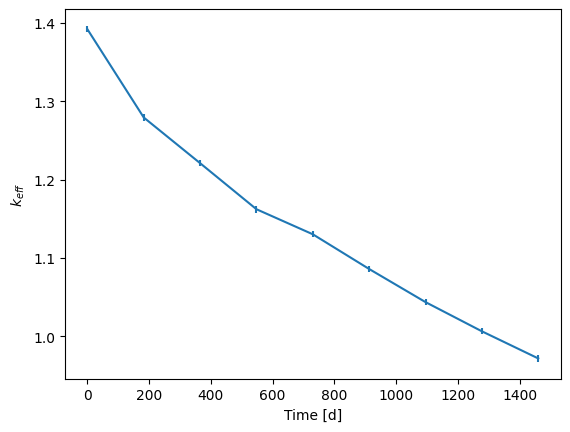

In [15]:
results = openmc.deplete.Results.from_hdf5("depletion_results.h5")
time, k = results.get_keff()
time /= (24 * 60 * 60)  # convert back to days from seconds


plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel('Time [d]')
plt.ylabel('$k_{eff}$')
plt.show()

Now with the `get_atoms()` we will load in the atom concentration of nuclides. The `"1"` refers to material with ID 1 (the fuel). We will set the unit to atom/barn-cm (which can be converted to atom/cm3 by multiplying the value with $10^{24}$; one can also convert to g/cm3 with some mind work). 

(Note that the variable name `_time` begins with an underscore, this is to highlight, that we already have a `time` array with converted time units which we intend to use, therefore we will store the time information provided by `get_atoms()` in a dummy array not intended to be used later)

Go ahead, and do the same for couple of other nuclides, for example Pu239, or Cs137. What do you think, why is Cs137 a good indicator of burnup?


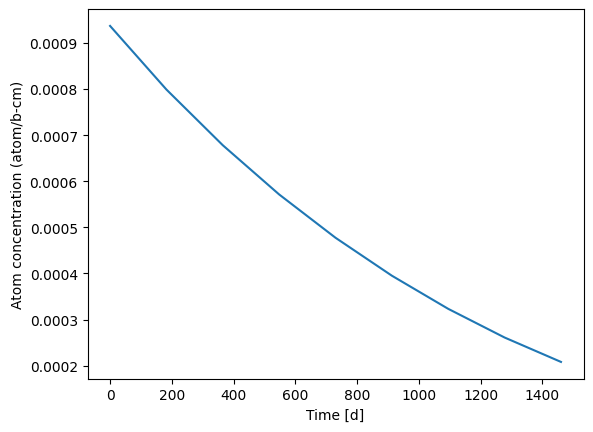

In [16]:
_time, u5 = results.get_atoms("1", "U235",nuc_units='atom/b-cm') #we call it _time, because we already have a time variable in the correct day units which we intend to use

plt.figure()
plt.plot(time, u5, label="U235")
plt.xlabel("Time [d]")
plt.ylabel("Atom concentration (atom/b-cm)")
plt.show()

Change this line to your conclusion!

# Experiment 2

Note, that this is home assignment HA3-3, thus you will not need to submit this part the day after the datalab, also you should modify HA3-3.ipynb instead.

A hypothetical dictatorship is desperately trying to build a nuclear weapon. Several years ago they have managed to acquire the design of a graphite moderated, CO2 cooled, natural uranium fuelled reactor. Your country's intelligence agency asked you to estimate the amount of plutonium the reactor produced in the previous years. You will need to make a pincell model of the reactor, and perform a depletion calculation.

The following information is available to you:

The fuel pin is made of UAl (density is 18.167 g/cm3) with the following atomic percentage:
- U235  0.00707444999
- U238  0.98792555
- Al27  0.005  

The cladding is made of a mixture of Magnesium and Aluminium (density is 1.738 g/cm3), with the following weight fractions:
- Mg 0.99
- Al27 0.01
(Note that you can add Mg as an element, and you can set weight fractions instead of atomic with `add_element('Mg',0.99,percent_type='wo')`) 

The fuel is cooled with CO2, however you know that due to its low density you can neglect it for now.

The moderator is made of graphite (density is 1.7 g/cm3). For this you can `add_nuclide('C0',1)` and set the thermal scattering laws with `add_s_alpha_beta('c_Graphite')`.

The geometry is the following:
- fuel outer radius is 1.45 cm
- clad outer radius is 1.5 cm (there is no gap between the clad and the fuel)
- the coolant channel outer radius is 3.25 cm
- outside the coolant we have the graphite moderator
- the pitch of the pincell is 20.0 cm.

The active core height is 52 cm, and there are 8120 such pincells in the reactor.

You know from your intel, that the reactor was running for 1785 continous days (which you can simulate with eight 223.125 days long steps) with a power density of 0.336 W/gHM. 

1. Create the openMC model for the pincell (you do not need to include any tallies)
2. Perform a depletion calculation
3. Look at the change of the k-eigenvalue over time, just because you are a curious reactor physicist
4. Estimate the total mass of Pu-239 at the end of the 1785 days operation (in kg)
5. Calculate the Plutonium-vector (the weight% of Pu-238, Pu-239, Pu-240, Pu-241, Pu-242 in the total amount of plutonium), to see whether the material would qualify as weapon grade or reactor grade plutonium (for this read up on weapon and reactor grade plutonium!).

(Note, in case you have difficulties with running the problem -which might happen with the virtual machine and limited computational resources-, then you can find the output files in the '/results' folder. Nevertheless, you still need to implement the geometry, run a simple k-eigenvalue calculation and create a plot of the geometry to show that your implementation is working. But then you can use the available output for processing).